# SPECFEM Users Workshop -- Day 3 (Oct. 7, 2022)

## Part 3C: Introduction to SeisFlows

- In this notebook we will introduce two open-source Python packages for facilitating/automating seismic imaging  
- **Objective**: To introduce and tour around SeisFlows and Pyatoa, and see how they can be used to simplify working with SPECFEM     
- These instructions should be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  
-----------

**Relevant Links:** 
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_3c_intro_seisflows.ipynb
- Completed Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_3c_intro_seisflows.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_0_container_testing.ipynb
- Day 1A Notebook (Intro SPECFEM): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem2d.ipynb
- Day 1B Notebook (Fwd. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb
- Day 2A Notebook (Adj. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2a_kernels.ipynb
- Day 3A Notebook (Simple Imaging): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_3a_imaging_simple.ipynb
- Day 3C Notebook (Advanced Imaging): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_3a_imaging_adv.ipynb

**adjTomo Software Suite:** 
- adjTomo: https://github.com/adjtomo
- SeisFlows GitHub Page: https://github.com/adjtomo/seisflows
- SeisFlows Documentation: https://seisflows.readthedocs.io/en/latest/
- Pyatoa GitHub Page: https://github.com/adjtomo/pyatoa
- Pyatoa Documentation: https://pyatoa.readthedocs.io/en/latest/


**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.


----------
## 0) Motivation

- Full waveform inversion / adjoint tomography is an algorithmically and computationally complex procedure  
- For real-world regional scale inversion, the number of events and stations can range from tens to hundreds  
- For 3 component seismograms, this can reach tens of thousands of waveforms and misfit quantification calculations over the course of hundreds of simulations  
- Automated workflow tools cut down on human time and operator error when running repetitive and iterative inversions  
- They also free up research time to focus on details of an inversion, rather than implementation  

![fwi_workflow](https://user-images.githubusercontent.com/23055374/194435095-8def121f-edc7-4408-be46-c0b84352ac6c.png)


### SeisFlows

- SeisFlows is one available tool for automating forward and adjoint simulations, as well as seismic inversions. 
- It comes with a built-in command line tool, and is written completely in Python  
- It provides `system` modules that allow it to interact with a variety of compute systems (laptops to HPC) using the same interface  
- SPECFEM2D and local capabilities allow quick prototyping and facilitate transition to 3D runs on clusters

### Pyatoa

- *Python's Adjoint Tomography Operations Assistant*: an ObsPy-like Python package used for misfit quantification  
- High-level wrapper for Pyflex, Pyadjoint, PyASDF, Pandas and ObsPy, all focused on the seismic imaging problem  
- Takes care of visualization and inversion assessment, implemented directly in the SeisFlows package but also operates as a standalone package 
- Motivated by tools and functionality I wish I had when performing a seismic inversion  

In [ ]:
! seisflows -h

---------
## 1) Automating the Forward Problem

- We'll first show how SeisFlows automates the forward problem  
- Users will need to supply starting model as well as real data or a target model  
- A single `parameters.yaml` file controls all of the SeisFlows workflow  

### 1a) Setting Up a SeisFlows Example Problem

- This setup procedure does exactly what we did in Day 1B, takes the Tape 2007 example problem and runs a forward simulation 
- This particular example uses the perturbation checkerboard model as the underlying model  
- See https://seisflows.readthedocs.io/en/devel/specfem2d_example.html for more examples
- See https://seisflows.readthedocs.io/en/devel/2D_example_walkthrough.html to figure out what's going on under the hood  

In [ ]:
# Required Python packages for today's notebook
from pyasdf import ASDFDataSet
from pyatoa import Inspector
from IPython.display import Image

In [ ]:
# Make sure we're in an empty working directory
! rm -r /home/scoped/work/day_3/intro_seisflows/example_3
! mkdir -p /home/scoped/work/day_3/intro_seisflows/example_3

%cd /home/scoped/work/day_3/intro_seisflows/example_3

# Setup Example 3, en-masse forward simulations. Don't run
! seisflows examples setup 3 -r  /home/scoped/specfem2d/ --with_mpi --nproc 1

In [ ]:
# Under the hood, the example SETUP procedure has run a forward simulation to generate our starting model  
! ls 
! echo
# Similar to the working directories we have been using during Days 1-3
! ls specfem2d_workdir
! echo
# OUTPUT_FILES contains model parameters
! ls specfem2d_workdir/OUTPUT_FILES_INIT
! echo
# 
! ls specfem2d_workdir/OUTPUT_FILES_INIT/*.bin

### 1b) The SeisFlows `parameters.yaml` file

- Similar to the SPECFEM `Par_file`, the SeisFlows `parameters.yaml` file controls the SeisFlows workflow
- Each 'module' of SeisFlows has a separate set of parameters
- The 'modules' of SeisFlows include: 
    - **Workflow:** the type of workflow and collection of tasks to run (e.g., forward, migration, inversion)  
    - **System:** controls interaction with the compute system (e.g., workstation, Slurm, Chinook)   
    - **Solver:** choose *which* external solver SeisFlows will interact with (i.e, specfem2d, 3d, 3d_globe (W.I.P.))
    - **Preprocess:** the preprocessing module to use for generating adjoint sources (i.e, default, Pyaflowa)
    - **Optimize:** the nonlinear optimization algorithm to use for model updates (e.g., gradient descent, L-BFGS)

In [ ]:
# Looking at the available modules
! head -n 33 parameters.yaml

In [ ]:
# Workflow: Forward parameters
! head -n 76 parameters.yaml | tail -n 43

In [ ]:
# Solver: SPECFEM2D parameters
! head -n 179 parameters.yaml | tail -n 70

### 1c) Shared `DATA/` Directory

- SeisFlows borrows files from the SPECFEM *DATA/* directory but requires some special formatting  
- SeisFlows will look for `ntask` events with the prefix `source_prefix`

In [ ]:
! seisflows par ntask
! seisflows par source_prefix

- For example, in SPECFEM2D with source prefix 'SOURCE', it will look for files called 'SOURCE_*'  
- The suffix can be event names, id numbers etc. They will be used to create solver directories during the workflow  

#### Required Paths

- SeisFlows needs to know the path to the *DATA/* directory to grab these files  
- SeisFlows also needs to know the path to the *bin/* directory so it can run SPECFEM executables  
- Finally, SeisFlows needs to know the path to your **model** files. The User is responsible for generating their mesh and model!  
- Additionally, SeisFlows maintains its own internal directory structure  

In [ ]:
! tail -n 60 parameters.yaml

### 1d) Swapping Modules

- SeisFlows can easily 'swap' modules from one to another  
- Used to facilitate the transition from a 2D, local, development environment, to a 3D HPC run  
- Replaces parameter set for **one** module only, leaving the others the same 

In [ ]:
! seisflows print modules

In [ ]:
! seisflows par preprocess

In [ ]:
! seisflows swap preprocess default

In [ ]:
! head -252 parameters.yaml | tail -n 73

In [ ]:
# Re-setting the preprocess module to None
! seisflows swap preprocess null

### 1e) Submit a Workflow

- Independent of your system, workflow etc., SeisFlows has only one entry point for running a workflow (`seisflows submit`)
- Under the hood, SeisFlows is doing what we manually did in the workshop, i.e., 
    - Generating working directories for each source
    - Checking acceptability of model parameters  
    - Setting the parameter file correctly for a forward simulation  
    - Running `xmeshfem2D` and `xspecfem2D` for each of the 10 sources  
 

In [ ]:
! seisflows submit

The workflow will be **complete** after it runs `xspecfem2D` for `source 010`

### 1f) Understanding a SeisFlows Working Directory

- Similar to SPECFEM, SeisFlows outputs log files, and output files  
- Most of the heavy lifting is done in the *scratch/* directory  
- Any files that should be saved permanently (seismograms, updated models during inversion) are storred in the *output/* directory  
- Any important log information (previously-used parameter files, error messages) are stored in the *logs/* directory  
- SeisFlows has an internal checkpointing routine, which takes advantage of the *sflog.txt* **state** file  
- See https://seisflows.readthedocs.io/en/devel/working_directory.html for more details

In [ ]:
# All of the SeisFlows workflow is contained here
! ls

In [ ]:
# Model files are stored in the output/ directory
! ls output
! echo
! ls output/MODEL_INIT

# We can use SeisFlows command line tools to plot the initial model
! seisflows plot2d MODEL_INIT vs --save m_init_vs.png
Image("m_init_vs.png")

In [ ]:
# Synthetic seismograms output by the solvers are stored here as well
! ls output/solver
! echo
! ls output/solver/001
! echo
! ls output/solver/001/syn

# We can use the SeisFlows command line tool to plot synthetics
! seisflows plotst output/solver/001/syn/AA.S00000[0-4].BXY.semd --save s_01_synthetics.png
Image("s_01_synthetics.png")

### `scratch/` directory

- The active working directory of SeisFlows where all of the heavy lifting takes place  
- Each module in the SeisFlows package may have it’s own sub-directory where it stores temporary work data  
- Additionally, we have two eval*/ directories where objective function evaluation (eval_func) and gradient evaluation (eval_grad) files are stored  

In [ ]:
! ls scratch

In [ ]:
! ls scratch/solver

In [ ]:
# Each solver directory is simply a SPECFEM workding directory controlled by SeisFlows
# The main solver is used for tasks which are not mandatory for all events (e.g., smoothing)  
! ls scratch/solver/mainsolver

--------------
## 2) Re-create a Kernel from Tape et al. 2007

- In this example we're going to try to re-create a part of a published figure  
- We are using the Tape 2007 example, which was introduced in Days 2 and 3 (homogeneous halfspace vs. checkerboard model)  
- See [SeisFlows Example \#2a docs page](https://seisflows.readthedocs.io/en/devel/specfem2d_example.html#re-creating-kernels-from-tape-et-al-2007) for guidance on what is going on    
- This example uses `Pyatoa` for waveform processing  
- **NOTE**: You can choose which event ID you're running by changing the integer after `--event_id`. Tape et al. show results for Event IDs 1 through 7  

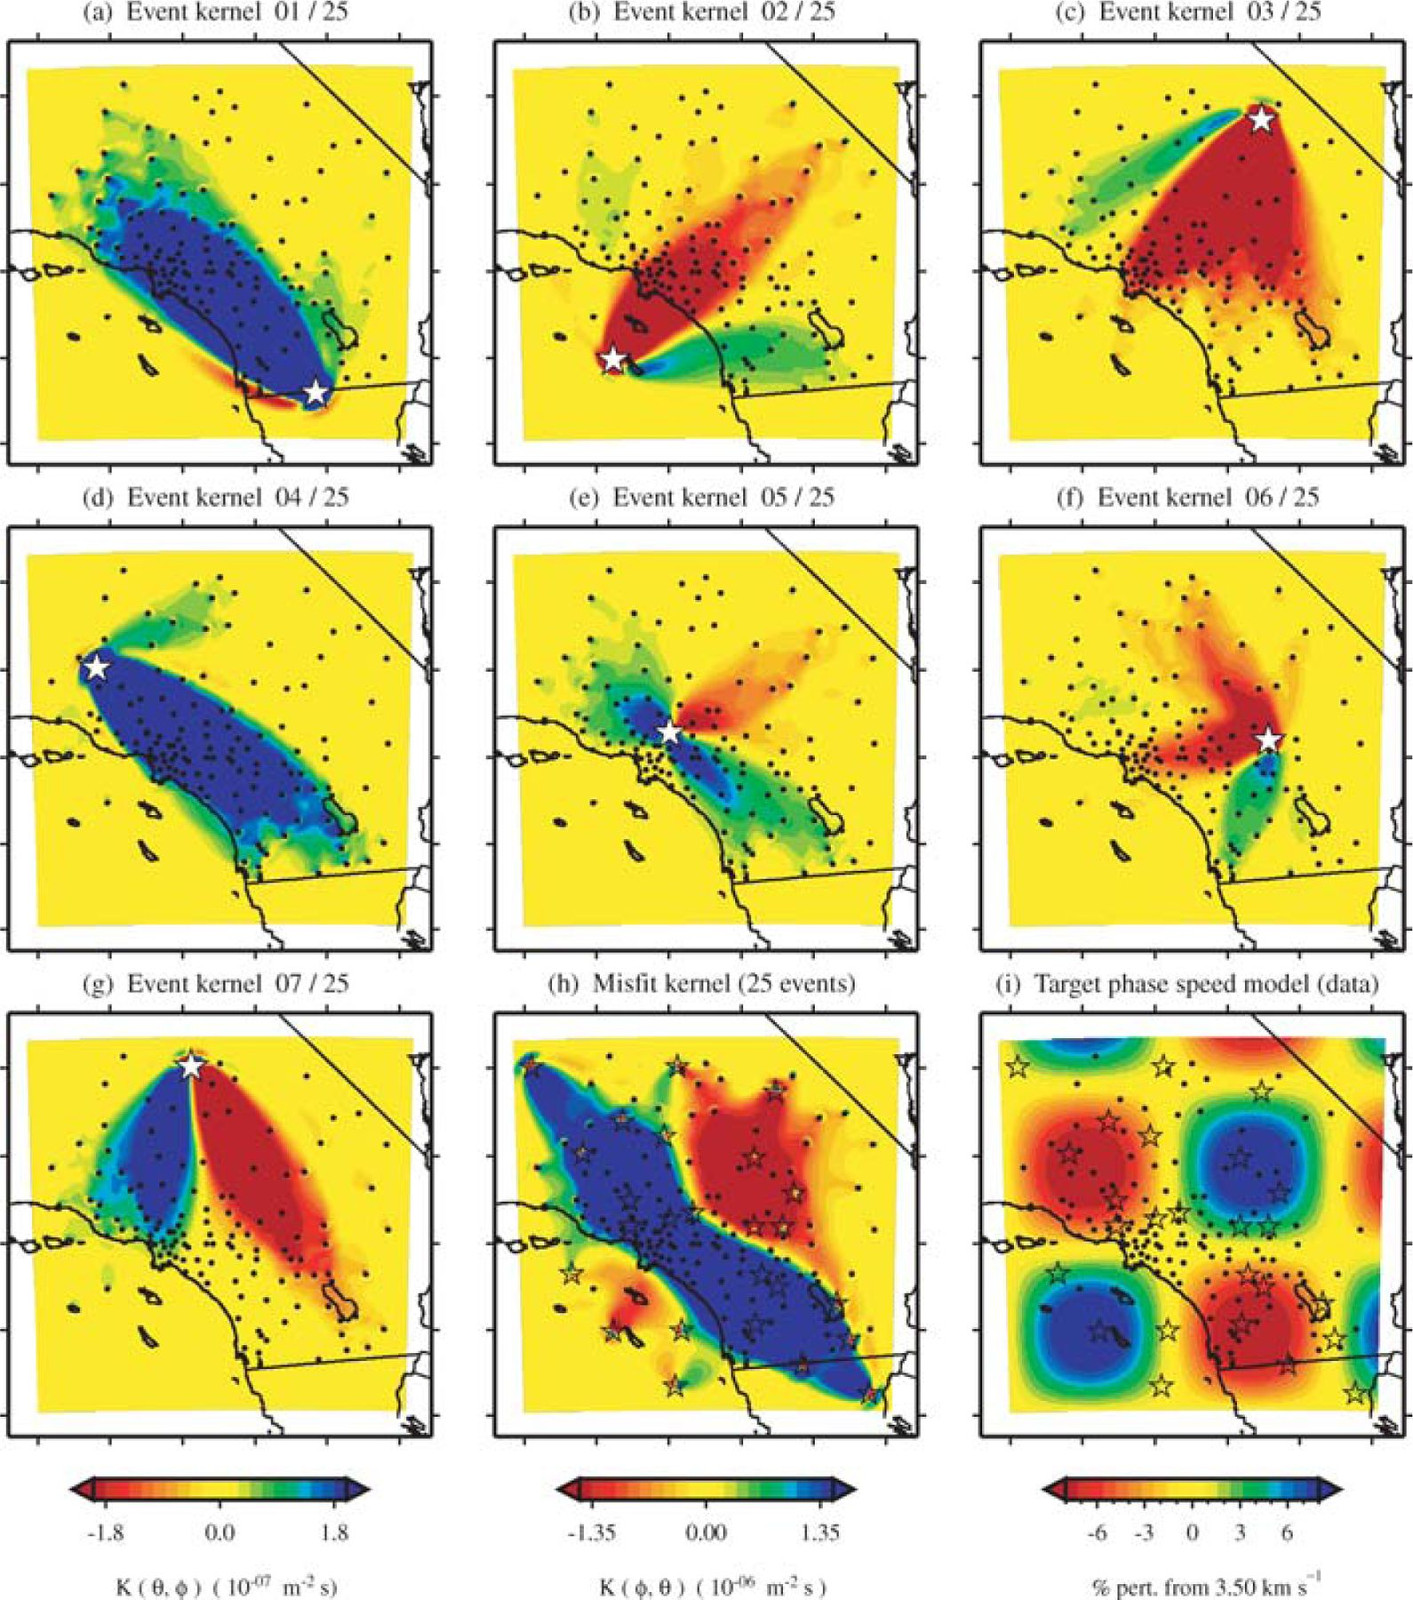
Caption from publication: *Construction of a misfit kernel. (a)–(g) Individual event kernels, each constructed via the method shown in Fig. 8 (which shows Event 5). The colour scale for each event kernel is shown beneath (g). (h) The misfit kernel is simply the sum of the 25 event kernels. (i) The source–receiver geometry and target phase‐speed model. There are a total of N= 25 × 132 = 3300 measurements that are used in constructing the misfit kernel (see Section 5).*

In [ ]:
# Run the example problem
! rm -r /home/scoped/work/day_3/intro_seisflows/example_2a
! mkdir -p /home/scoped/work/day_3/intro_seisflows/example_2a

%cd /home/scoped/work/day_3/intro_seisflows/example_2a

# Setup the example problem and run Example 2
! seisflows examples setup 2 -r /home/scoped/specfem2d --with_mpi --niter 1 --event_id 7  # <-- Choose your event by changing this value
! seisflows par stop_after evaluate_gradient_from_kernels  # Tell SeisFlows to stop mid-inversion
! seisflows submit

------------
You'll know the example problem is finished when you see the following message
```bash
2022-10-07 00:29:02 (I) | stop workflow at `stop_after`: evaluate_gradient_from_kernels
```

In [ ]:
# Plots the gradient output by SeisFlows, compare to the figure above
! seisflows plot2d GRADIENT_01 vs_kernel --savefig g_01_vs.png
Image("g_01_vs.png")

### 2a) Understanding `Pyaflowa` Outputs

- Pyaflowa is the name given to the SeisFlows module which takes advantage of Pyatoa to perform preprocessing  
- Pyaflowa generates outputs each time misfit is quantified, which you can use to understand your workflow  
- Because we *stopped* our workflow prematurely, Pyaflowa's files are still in the *scratch/* directory  
- In a normally operating inversion, these files would be exported to the *output/* directory  

In [ ]:
! ls scratch/preprocess

In [ ]:
# Waveform misfit figures are saved for each source-receiver pair
! ls scratch/preprocess/figures

>__NOTE:__ Since this is a PDF file, we'll have to navigate to `home -> work -> example_2a -> output -> pyaflowa -> figures` to visualize

In [ ]:
# Pyatoa Log files define the misfit quantification procedure for each event
! ls scratch/preprocess/logs
! echo
! head -75 scratch/preprocess/logs/007_i01_s00.log

### 2c) Pyatoa Stores Data in ASDFDataSets

- All waveform data, misfit windows (if available) and adjoint sources are stored in ASDFDataSets  
- ASDFDataSets are hierarchical data storage files for seismic data (built on HDF5)  
- For more information see: https://pyatoa.readthedocs.io/en/devel/storage.html

In [ ]:
# All waveform data, misfit windows (if available) and adjoint sources are stored in ASDFDataSets
! ls scratch/preprocess/datasets
ds = ASDFDataSet("scratch/preprocess/datasets/007.h5")
print(ds)

In [ ]:
print(f"{ds.waveforms.list()}\n\n"
      f"{ds.waveforms.AA_S000000}\n\n"
      f"{ds.waveforms.AA_S000000.synthetic_i01s00}\n\n")

ds.waveforms.AA_S000000.synthetic_i01s00.plot(show=False)

In [ ]:
print(f"{ds.auxiliary_data}\n\n"
      f"{ds.auxiliary_data.AdjointSources}\n\n"
      f"{ds.auxiliary_data.AdjointSources.i01}\n\n",
      f"{ds.auxiliary_data.AdjointSources.i01.s00}\n\n"
      f"{ds.auxiliary_data.AdjointSources.i01.s00.AA_S000000_BXY}\n\n")

-----------
## 3) Run a Large-Scale Inversion w/ Pyatoa + L-BFGS

- Illustrate a multi-event, multi-station inversion workflow  
- We will run 3 iterations to show the L-BFGS optimization algorithm operates  
- Pyatao will again be used as the preprocess module

In [ ]:
# Run the example problem
! rm -r /home/scoped/work/day_3/intro_seisflows/example_2
! mkdir -p /home/scoped/work/day_3/intro_seisflows/example_2

%cd /home/scoped/work/day_3/intro_seisflows/example_2

# Setup the example problem and run Example 2
! seisflows examples setup 2 -r /home/scoped/specfem2d --with_mpi --niter 3 --ntask 4 --nsta 10  
! seisflows par pyflex_preset default  # Turn on windowing so that we can illustrate Pyatoa's Inspector class
! seisflows submit

----------
You'll know the example above is finished when you get the following log message  

```bash
////////////////////////////////////////////////////////////////////////////////
                             COMPLETE ITERATION 03                              
////////////////////////////////////////////////////////////////////////////////
2022-10-07 01:02:26 (I) | setting current iteration to: 4
```

### 3a) Understanding Inversion Outputs

- SeisFlows by default has stored gradients, updated models and preprocessing files in the *output/* directory  
- Preprocessing files are stored in *output/pyaflowa*

In [ ]:
! ls output

In [ ]:
# Visualize updated models 
! seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image("m_init_vs.png")

In [ ]:
# Visualize updated models 
! seisflows plot2d MODEL_01 vs --savefig m_01_vs.png
Image("m_01_vs.png")

In [ ]:
# Visualize updated models 
! seisflows plot2d MODEL_02 vs --savefig m_02_vs.png
Image("m_02_vs.png")

In [ ]:
# Visualize updated models 
! seisflows plot2d MODEL_03 vs --savefig m_03_vs.png
Image("m_03_vs.png")

In [ ]:
# Visualize updated models 
! seisflows plot2d MODEL_TRUE vs --savefig m_true_vs.png
Image("m_true_vs.png")